In [1]:
import numpy as np
import torch
import pandas as pd

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

### PMF (Probabilistic Matrix Factorization)
is a statistical approach to collaborative filtering where the user–item rating matrix is assumed to be generated by the interaction of latent factors (user and item embeddings), plus some Gaussian noise.

### Collaborative filtering
It is a solution where we have problems involving 'n' users and 'm' items and the aim is to find which items are most likely to be useful to which users. 
for example, recommending movies (such as on Netflix)

The key foundational idea is that of latent factors:hidden dimensions that represent the underlying preferences of users and characteristics of items.
For example, in a movie recommendation system, latent factors might represent abstract qualities like “action intensity”, “romantic content”, or “comedic tone.”
A user who consistently rates action movies highly will have a strong preference for the “action intensity” factor, and movies with high scores on that factor will be recommended to them — even if the user has never rated those specific movies before.

In [3]:
path = untar_data(URLs.ML_100k)


In [4]:
## As columns are inside u.data and are tab seprated '/t' so we manually use delimiter and read data from u.data
ratings=pd.read_csv(path/'u.data',delimiter='\t',header=None,names=['user','movie','rating','timestamp'])

In [5]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
## function to create Pivot table with least nan for better understadnig of ratings 
ratings_matrix=ratings.pivot(index='user',columns='movie',values='rating').dropna(thresh=100)
subset_movies = ratings_matrix.iloc[:, :10]
na_counts = subset_movies.isna().sum(axis=1) # Counted missing values per user column wise
subset_movies_sorted = subset_movies.loc[na_counts.sort_values().index]# Sorted users by how many NaNs they have (fewest first)
clean_subset = subset_movies_sorted.head(15) # top N users
clean_subset

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


movie,1,2,3,4,5,6,7,8,9,10
user,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
435,5.0,4.0,3.0,4.0,2.0,NaN,4.0,3.0,4.0,5.0
393,3.0,4.0,3.0,4.0,3.0,NaN,4.0,3.0,4.0,NaN
406,4.0,NaN,3.0,2.0,4.0,NaN,4.0,4.0,5.0,3.0
682,4.0,3.0,3.0,3.0,3.0,NaN,4.0,3.0,3.0,NaN
561,2.0,3.0,3.0,3.0,NaN,NaN,5.0,3.0,4.0,3.0
303,5.0,3.0,3.0,4.0,2.0,NaN,4.0,5.0,5.0,NaN
378,4.0,2.0,NaN,3.0,3.0,NaN,4.0,4.0,5.0,3.0
280,4.0,3.0,2.0,3.0,4.0,NaN,4.0,5.0,5.0,NaN


In [7]:
## Function to create a pivot table showing users & movies with the least NaNs
def ratings_pivot(n_users,n_movies,ratings):
    ratings_matrix=ratings.pivot(index='user',columns='movie',values='rating').dropna(thresh=100)
    subset_movies = ratings_matrix.iloc[:, :n_movies]
    na_counts = subset_movies.isna().sum(axis=1) # Counted missing values per user column wise
    subset_movies_sorted = subset_movies.loc[na_counts.sort_values().index]# Sorted users by how many NaNs they have (fewest first)
    clean_subset = subset_movies_sorted.head(n_users) # top N users
    return clean_subset

In [8]:
ratings_pivot(10,10,ratings)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


movie,1,2,3,4,5,6,7,8,9,10
user,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
435,5.0,4.0,3.0,4.0,2.0,NaN,4.0,3.0,4.0,5.0
393,3.0,4.0,3.0,4.0,3.0,NaN,4.0,3.0,4.0,NaN
406,4.0,NaN,3.0,2.0,4.0,NaN,4.0,4.0,5.0,3.0
682,4.0,3.0,3.0,3.0,3.0,NaN,4.0,3.0,3.0,NaN
561,2.0,3.0,3.0,3.0,NaN,NaN,5.0,3.0,4.0,3.0
303,5.0,3.0,3.0,4.0,2.0,NaN,4.0,5.0,5.0,NaN
378,4.0,2.0,NaN,3.0,3.0,NaN,4.0,4.0,5.0,3.0
280,4.0,3.0,2.0,3.0,4.0,NaN,4.0,5.0,5.0,NaN


## To fill na:
If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors, and so forth, and we knew the same information about each movie, then a simple way to fill in this table would be to do a dot product of this information together for each movie.

## To learn these latent factor we can randomly intialize them and use gradient descent to learn the factors.


##Step1 We are intializing with five latent factors randomly for each user and movie, wherein each user will have a set of these factors and each movie will have a set of these factors & the values are randomly intialized for each factor

##Step 2: Calculate  our predictions by taking the dot product of each movie with each user.

##Step 3 : We can calculate loss example MSE and henceforth optimize our paramters

In [9]:
## We can use movie name inplace of id
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [10]:
ratings=pd.merge(ratings, movies, on='movie')

In [11]:
ratings

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)



We can then build a DataLoaders object from this table. By default, it takes the first column for the user, the second column for the item (here our movies), and the third column for the ratings. We need to change the value of item_name in our case to use the titles instead of the IDs:

In [12]:

dls=CollabDataLoaders.from_df(ratings,item_name='title',bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


## dls.classes : is a dictionary that stores all the categories (classes) for each categorical column — i.e., the unique values that were encoded.
Post creating of FastAI DataLoaders object
FastAI automatically:
-Encodes all unique user IDs and movie titles into categories and Builds lookup vocabularies (like mapping each user/movie to an integer index)
examole : dls.classes['user'] gives unique user


In [13]:
n_users  = len(dls.classes['user'])## length of unique user
n_movies = len(dls.classes['title']) ##unique movie length
n_factors = 5 ## randomly intializing with 5 latent factors

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)
user_factors

tensor([[-1.0827,  0.2138,  0.9310, -0.2739, -0.4359],
        [-0.5195,  0.7613, -0.4365,  0.1365,  1.3300],
        [-1.2804,  0.0705,  0.6489, -1.2110,  1.8266],
        ...,
        [ 0.8009, -0.4734, -0.8962, -0.7348, -0.0246],
        [ 0.3354, -0.8262, -0.1541,  0.4699,  0.4873],
        [ 2.4054, -0.2156, -1.4126, -0.2467,  1.0571]])

Now the challenge  is to calculate the result for a particular movie and user combination we have to look up at the index of the movie and in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors. But look up in an index is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.

Fortunately, it turns out that we can represent look up in an index as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index 3

In [14]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3 #It gives us the same vector as the one at index 3 in the matrix:





tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [15]:
user_factors[3]


tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Embedding
However most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.

Hence, embedding layers = optimized one-hot × matrix trick.

An embedding is just a table of numbers that your model learns —where each row represents something (like a user or movie) as a vector of features.
It a compact learned representation of say user 1 that the neural net can process further.

## Or it can be said as :
“A one-hot encoded vector is being multiplied by all the rows of learnable features (say there are three), and thus gives a final embedding vector which is the by-product of parameters and indexing.”

## Imp of embeddings
Each dimension of the embedding vector represents a latent feature — something the model discovers automatically, like:
For movies: genre preference, popularity, mood

Suppose our model learns 5 latent factors for each movie.so we can literally find related movies by measuring cosine similarity between embeddings!

Movie A: [0.9, 0.2, 0.1, 0.5, 0.7]

Movie B: [0.8, 0.3, 0.1, 0.6, 0.7]




In [16]:
## Custom model using pytorch Module

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [17]:
x,y=dls.one_batch()
x.shape

torch.Size([64, 2])

In [18]:
#Defining learner
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat()) ##MSELossFlat :before computing the loss it flattens both tensors —

In [19]:
##fit our model 
learn.fit_one_cycle(5, 5e-3)


epoch,train_loss,valid_loss,time
0,1.323817,1.340935,00:06
1,1.017078,1.092095,00:05
2,0.873056,0.974699,00:05
3,0.762055,0.897630,00:05
4,0.719645,0.874279,00:05


In [20]:
##Since the loss is MSE, a validation loss of around 0.87 means the average squared error between predicted and true ratings is about 0.87.
#This is a reasonable output however improvement can be made as below

## Improvement

In [21]:
#First thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. 
"""For this we can use Sigmoid to force the model output"""
class DotProduct(Module):
    def __init__(self,n_users,n_movies,n_factors,y_range=(0,5.5)):
        self.user_factors=Embedding(n_users,n_factors)
        self.movie_factors=Embedding(n_movies,n_factors)
        self.y_range=y_range
        
    def forward(self,x):
        users=self.user_factors(x[:,0])
        movies=self.movie_factors(x[:,1])
        return sigmoid_range((users*movies).sum(dim=1),*self.y_range)##sigmoid_range(Preds,y_range (0.5-5))        
        

In [22]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938609,0.993308,00:06
1,0.648320,0.945030,00:06
2,0.464125,0.951017,00:06
3,0.358895,0.952974,00:05
4,0.346770,0.952382,00:05


# we can further improve it


In [23]:
# Step 2 of improvement: In this we will try to handle bias as  some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others.

In [24]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [25]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.848497,0.934887,00:06
1,0.552631,0.908134,00:06
2,0.406799,0.940988,00:06
3,0.317884,0.951607,00:06
4,0.297811,0.952230,00:06


## Model didnt work well so we can implement additional improvements such as weight decay


Weight decay, or L2 regularization, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

In [26]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.907658,0.954014,00:06
1,0.672682,0.894207,00:06
2,0.537963,0.877620,00:06
3,0.454540,0.860992,00:06
4,0.433001,0.857460,00:06


# The output is much better and model is not overfitting 

In [47]:
## Implementing Embedding from scractch without using Embedinng class using nn.Parameter of pytorch

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))


In [48]:
# Crate our model wuthout Using embeding
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [49]:

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.900424,0.948120,00:07
1,0.670649,0.885692,00:07
2,0.533216,0.865458,00:07
3,0.462604,0.851651,00:07
4,0.429410,0.848580,00:07


# Interpreting Embeddings and Biases

In [37]:
# captures how much people tend to like or dislike a movie overall — independent of who’s watching it.
movie_bias=learn.model.movie_bias.squeeze() 
idx=movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idx]


['Children of the Corn: The Gathering (1996)',
 'Showgirls (1995)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Leave It to Beaver (1997)',
 'Grease 2 (1982)']

The above movie have low bias :
A movie with low bias disappoints everyone — even fans of that genre.The movie fits the user’s taste profile But it still ends up with a low predicted rating


In [50]:
movie_bias=learn.model.movie_bias.squeeze() 
idx=movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idx]

['Shawshank Redemption, The (1994)',
 'Rear Window (1954)',
 'Good Will Hunting (1997)',
 'Star Wars (1977)',
 'Titanic (1997)']

The above movie have high bias: It means movies that people love, even if they wouldn’t normally like that kind of movie.

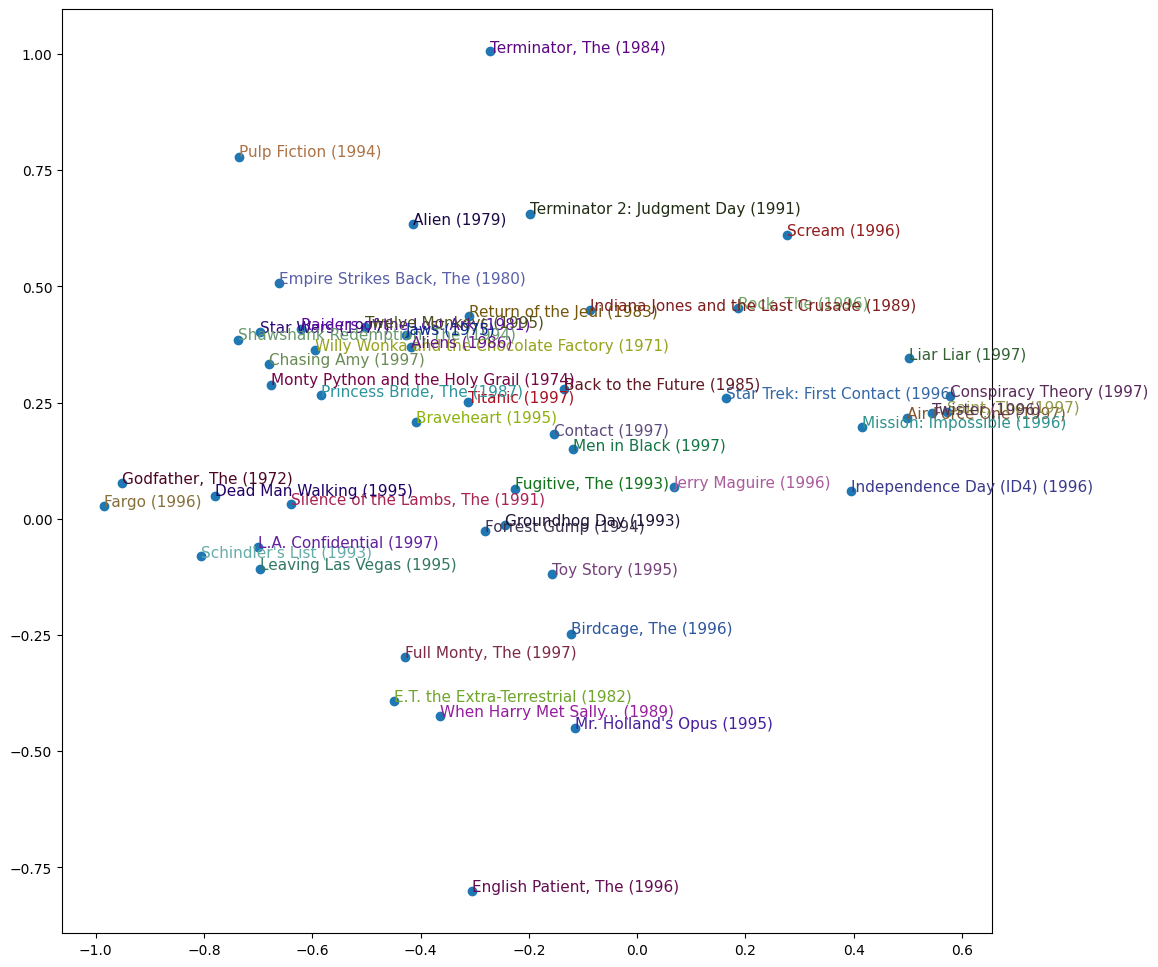

In [51]:
#Applying PCA(Principal component Analysis to understad the embedding )
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3) # Reduces it to 3 principal components (directions capturing most variance in data).
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [52]:
#short fastaiCode snippet to create above model and train it
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)



epoch,train_loss,valid_loss,time
0,0.911171,0.948138,00:06
1,0.691107,0.889512,00:06
2,0.529252,0.866796,00:06
3,0.467807,0.851331,00:07
4,0.434742,0.848141,00:06


In [53]:
# Embedding distance : we can find movie similar to one movie using cosine similarity
#Cosine similarity measures how close two embeddings are in direction (values near +1 mean very similar).
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Guantanamera (1994)'

## Bootstrapping a Collaborative Filtering Model¶

How to deal with problem  when we have no users, and therefore no history to learn from. What products do we recommend to your very first user?

1.Assign new users the average of all existing user embeddings — simple but unrealistic since the “average taste” may not represent any real user.

2.Instead of the mean, start new users with the embedding of a typical or “average-taste” user whose preferences reflect the overall population.

3.use user metadata or signup survey responses (e.g., preferred genres, demographics) to predict an initial embedding vector via a separate tabular model.

4.Ask a few targeted questions at signup (like Netflix or Pandora) to quickly infer user preferences and initialize their recommendation profile.

## Neural Collaborative Filtering (NCF): Deep Learning for Collaborative Filtering¶


In [59]:
#below code looks at all the categorical columns (like user IDs, movie titles, etc.), checks how many unique values each has, and returns the ideal embedding sizes for them.
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [60]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [61]:
model = CollabNN(*embs)

In [62]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.905551,0.953584,00:07
1,0.856923,0.905972,00:07
2,0.821733,0.874885,00:07
3,0.761462,0.863285,00:07
4,0.771652,0.861475,00:07
